In [2]:
import sys
import os
sys.path.append("../..")

from omegaconf import OmegaConf
from sdofm.datasets.SDOML import SDOMLDataModule, SDOMLDataset
from sdofm.datasets.RandomIntervalSDOML import RandomIntervalSDOMLDataset, RandomIntervalSDOMLDataModule 
from sdofm.datasets.BrightSpotsSDOML import BrightSpotsSDOMLDataset, BrightSpotsSDOMLDataModule 
from rlxutils import subplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sdofm.utils import stonyhurst_to_patch_index
from progressbar import progressbar as pbar
from sdofm.constants import ALL_COMPONENTS, ALL_WAVELENGTHS, ALL_IONS
from rlxutils import ElapsedTimes
import torch

In [3]:
from importlib import reload
from sdofm.models import unet
reload(unet)

channel_to_predict = 6
model = unet.UNet(n_channels=12, n_classes=1, bilinear=False, use_embeddings_block=False, size_factor=4)
psize = [np.prod(i.shape) for i in model.parameters()]
print ("model total parameters    ", sum(psize))

model total parameters     2229650


In [4]:
x = torch.rand(4,12,512,512)
model(x).shape

torch.Size([4, 1, 512, 512])

In [5]:
def forward_and_loss_encoder_decoder(model, batch):
    
        image_stack = batch['image_stack'].cuda()
        bright_spots = batch['bright_spots'].cuda()
        # run model
        pred = model(image_stack)

        # compute loss
        loss = loss_fn(bright_spots, pred)
        return loss
    
def forward_and_loss_embedding(model, batch):
    
        image_stack = batch['image_stack'].cuda()

        enc = model.forward_encode(image_stack)
        emb = model.forward_to_embeddings(enc)
        fwemb = model.forward_from_embeddings(emb)

        loss = loss_fn(enc, fwemb)
        return loss

In [6]:
def train_loop(model, dataloader, optimizer, num_epochs=100, forward_and_loss_fn = forward_and_loss_encoder_decoder):
    lossh, lossvalh = [], []
    predictions, targets = [], []
    
    try:

        for epoch in range(num_epochs):
            t0 = datetime.now() 

            for step, batch in enumerate(dataloader):
                
                loss = forward_and_loss_fn(model, batch)

                # backpropagate and update weights
                loss.backward()
                optimizer.step()

                lossvaln = 0.
                # cosmetics
                lossn = loss.detach().cpu().numpy()
                lossh.append(lossn)

                lossvalh.append(lossvaln)


                psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in model.parameters()])    
                lossm = np.mean(lossh[-100:])
                lossvalm = np.mean(lossvalh[-100:])
                epoch_time = (datetime.now() - t0).seconds

                checksum = {k:float(f"{v:3f}") for k,v in model.param_checksum().items()}

                print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} lossval {lossvalm:.5f} params {psummary:.7f} epoch_time {epoch_time} secs {checksum}", end="\r")
            print()
    except KeyboardInterrupt:
        print ("\nkeyboard interrupt")
            
    # return the last batch
    return lossh, batch

In [7]:
def ploth(h, name='loss', ylim=None, ax=None):
    lossp = pd.DataFrame(h, columns=[name])
    lossp[f'smoothed {name}'] = lossp[name].rolling(100).mean()
    lossp.plot(alpha=.5, ax=ax)
    plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
    if ylim is not None:
        plt.ylim(*ylim)
        

In [8]:
cfg = OmegaConf.load("../../experiments/default.yaml")

In [9]:
data_module = BrightSpotsSDOMLDataModule(
    # hmi_path=os.path.join(
    #     self.cfg.data.sdoml.base_directory, self.cfg.data.sdoml.sub_directory.hmi
    # ),
    hmi_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.hmi,
    ),
    aia_path = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.aia,
    ),    
    eve_path = None,
    components  = cfg.data.sdoml.components,
    wavelengths = cfg.data.sdoml.wavelengths,
    ions        = cfg.data.sdoml.ions,
    frequency   = cfg.data.sdoml.frequency,
    batch_size  = 4,
    num_workers = 14,
    blosc_cache = "/home/rlx/blosc_cache",
    start_date = '2011-01-01',
    end_date   = '2014-12-31',
    val_months  = cfg.data.month_splits.val,
    test_months = cfg.data.month_splits.test,
    holdout_months = cfg.data.month_splits.holdout,
    cache_dir = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_HMI_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_HMI_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


## instantiate model (encoder + time delta predictor) 

In [10]:
from sdofm.models import unet

reload(unet)
channel_to_predict = 6
model = unet.UNet(n_channels=12, n_classes=1, bilinear=True, use_embeddings_block=True, size_factor=4)
#model = torch.load("unetmodel_12ch_1classes_bilinear_sizefactor4.ckpt")
psize = [np.prod(i.shape) for i in model.parameters()]
print ("model total parameters    ", sum(psize))

model total parameters     1571378


In [11]:
self = model
model_name = f"unetmodel_{self.n_channels}ch_{self.n_classes}classes_{'bilinear' if self.bilinear else 'notbilinear'}_sizefactor{self.size_factor}"
model_name

'unetmodel_12ch_1classes_bilinear_sizefactor4'

## send models to cuda and init optimizer

In [12]:
model = model.cuda()

optimizer_unet = torch.optim.Adam(model.encoder_decoder_layers.parameters(), lr=1e-5)
optimizer_embeddings = torch.optim.Adam(model.embeddings_decoder_layers.parameters(), lr=1e-5)
#optimizer_embeddings = torch.optim.Adam(model.embeddings_layers.parameters(), lr=1e-3)

loss_fn = lambda a,b: torch.sqrt( torch.mean((a-b)**2 ) )
#loss_fn = lambda a,b: torch.mean((a-b)**2 )

In [13]:
model.param_checksum()

{'encoder': 740.089111328125,
 'embeddings': -32.824066162109375,
 'decoder': 289.7908630371094}

# train encoder - decoder, bypass embeddings

dataloader len 29730
epoch   0 step 29729 loss 0.03422 lossval 0.00000 params 0.4259106 epoch_time 7450 secs {'encoder': -10608.295898, 'embeddings': -32.824066, 'decoder': -5602.223145}


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1743d9870>
Traceback (most recent call last):
  File "/opt/conda/envs/sdofm/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/sdofm/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/envs/sdofm/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/envs/sdofm/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/conda/envs/sdofm/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/opt/conda/envs/sdofm/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 



keyboard interrupt


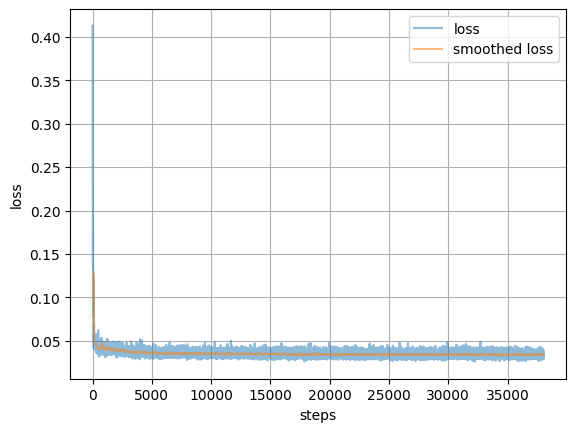

In [14]:
model = model.cuda()
model.use_embeddings_block = False
dataloader = data_module.train_dataloader()
print ("dataloader len", len(dataloader))
lossh, batch = train_loop(model, dataloader, optimizer_unet)
ploth(lossh)

In [15]:
1

1

In [45]:
#torch.save(model, f"{model_name}.ckpt")
model_name

'unetmodel_12ch_1classes_bilinear_sizefactor4'

(0.0, 0.1)

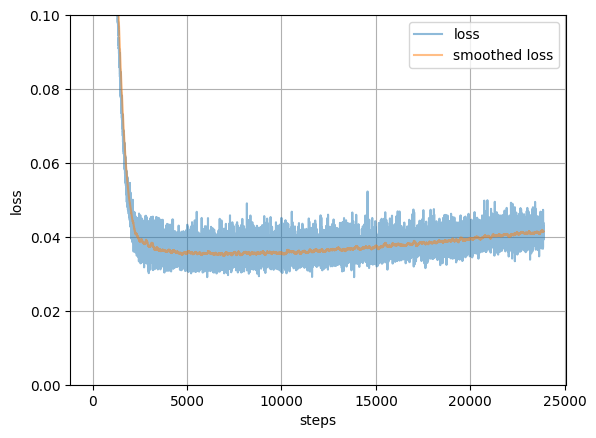

In [13]:
ploth(lossh)
plt.ylim(0,.1)

fw


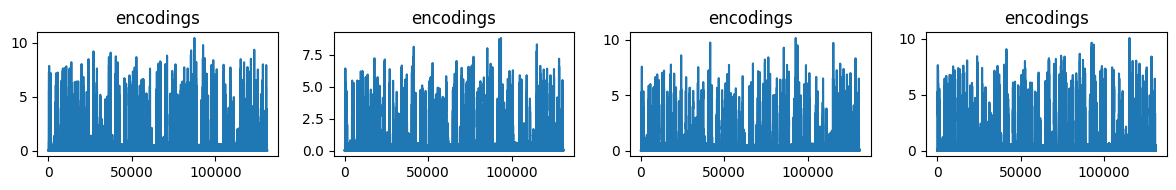

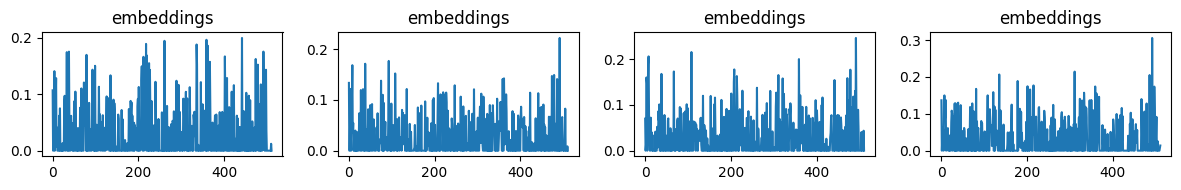

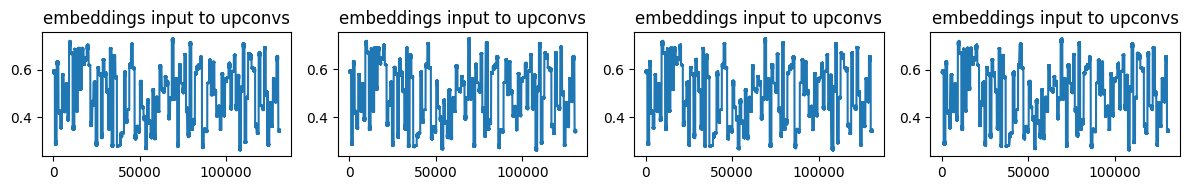

In [29]:
reload(unet)
model = torch.load(f"{model_name}.ckpt").cpu()
enc = model.forward_encode(image_stack)
emb = model.forward_to_embeddings(enc)
fwemb = model.forward_from_embeddings(emb)

rfwemb = fwemb.reshape(len(fwemb),-1)
renc   = enc.reshape(len(enc),-1)

for ax,i in subplots(len(renc), usizey=2):
    plt.plot(renc[i].detach().numpy())
    plt.title("encodings")

for ax,i in subplots(len(emb), usizey=2):
    plt.plot(emb[i].detach().numpy())
    plt.title("embeddings")
    
for ax,i in subplots(len(rfwemb), usizey=2):
    plt.plot(rfwemb[i].detach().numpy())
    plt.title("embeddings input to upconvs")


In [32]:
model.down4.maxpool_conv[1].output_act_fn

AttributeError: 'DoubleConv' object has no attribute 'output_act_fn'

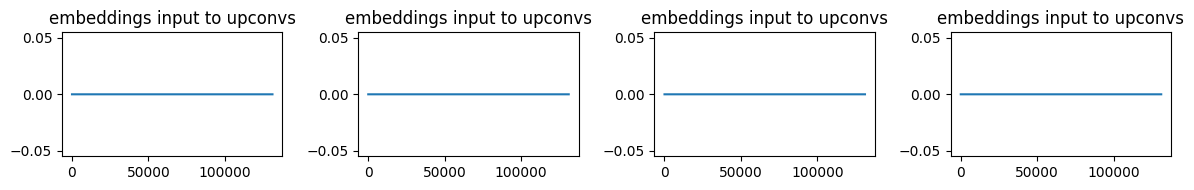

In [17]:
for ax,i in subplots(len(rfwemb), usizey=2):
    plt.plot((renc[i]-rfwemb[i]).detach().numpy())
    plt.title("embeddings input to upconvs")


In [44]:
rfwemb.sum()

tensor(1.8267e+08, grad_fn=<SumBackward0>)

# train embeddings + decoder, freeze encoder

In [16]:
model = torch.load(f"{model_name}.ckpt").cuda()
optimizer_embeddings = torch.optim.Adam(model.embeddings_decoder_layers.parameters(), lr=1e-5)
#loss_fn = lambda a,b: torch.sqrt( torch.mean((a-b)**2 ) )
loss_fn = lambda a,b:  torch.mean((a-b)**2 ) 


dataloader len 29730
epoch   0 step 18703 loss 0.44646 lossval 0.00000 params 0.4334546 epoch_time 2894 secs {'encoder': 243.485931, 'embeddings': -302546.1875, 'decoder': -240.787704}}
keyboard interrupt


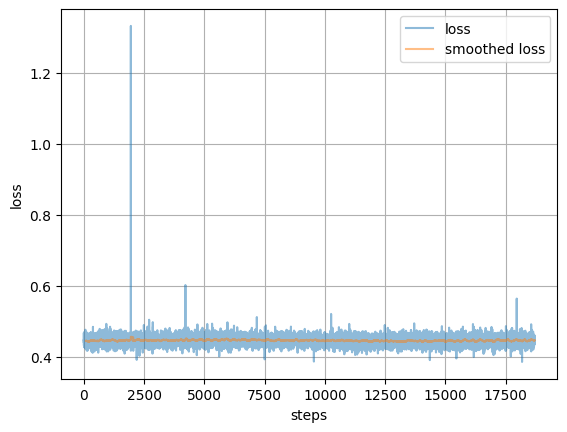

In [ ]:
model.use_embeddings_block = True
#dataloader = data_module.train_dataloader()
print ("dataloader len", len(dataloader))
lossh, batch = train_loop(model, dataloader, optimizer_embeddings, forward_and_loss_fn=forward_and_loss_embedding, num_epochs=2)
ploth(lossh)

In [83]:
#torch.save(model, f"{model_name}.ckpt")
model_name

'unetmodel_12ch_1classes_bilinear_sizefactor4'

# visualize stuff

In [15]:
#model = torch.load(f"{model_name}.ckpt")

In [84]:
dataloader = data_module.train_dataloader()
vizdl = dataloader
viz_iter = iter(vizdl)

In [85]:
batch = next(viz_iter)
modelcpu = model.cpu()

In [96]:
image_stack = batch['image_stack']
bright_spots = batch['bright_spots']
modelcpu.use_embeddings_block = True
pred = modelcpu(image_stack)
image_stack.sum()

tensor(496640.5625)

In [97]:
modelcpu = model.cpu()
enc = modelcpu.forward_encode(image_stack)
emb = modelcpu.forward_to_embeddings(enc)
fwemb = modelcpu.forward_from_embeddings(emb)


In [98]:
enc.shape, fwemb.shape

(torch.Size([4, 128, 32, 32]), torch.Size([4, 128, 32, 32]))

In [99]:
batch['timestamp']

['2014-01-21 16:24:00',
 '2012-09-04 19:36:00',
 '2011-02-15 21:36:00',
 '2013-03-09 23:00:00']

In [100]:
modelcpu = model.cpu()
x = modelcpu.forward_encode(image_stack)
emb = modelcpu.forward_to_embeddings(x)
fwemb = modelcpu.forward_from_embeddings(emb)
emb.shape, fwemb.shape


(torch.Size([4, 512]), torch.Size([4, 128, 32, 32]))

In [102]:
image_stack.sum()

tensor(496640.5625)

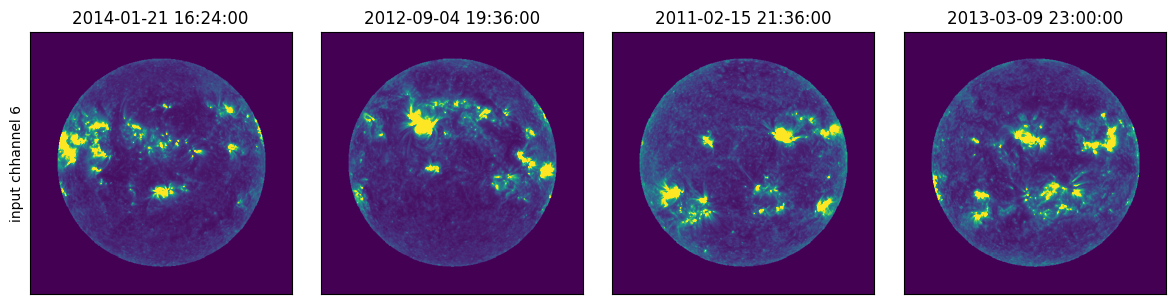

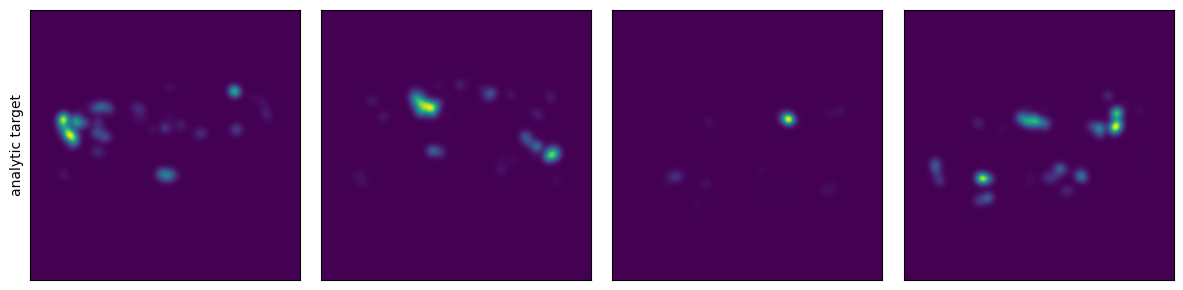

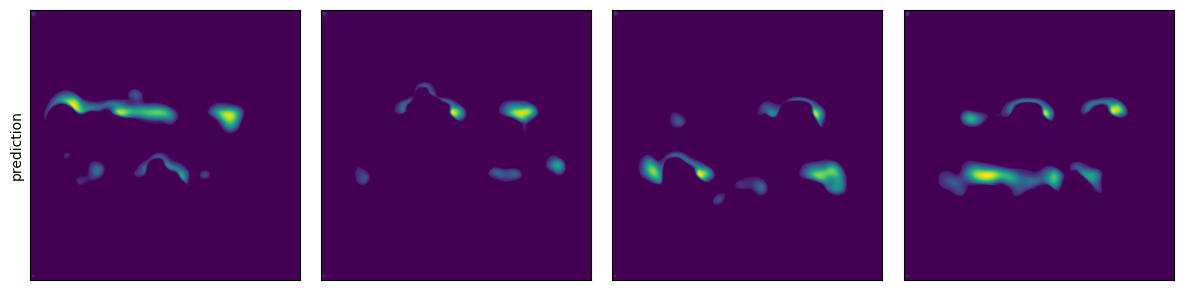

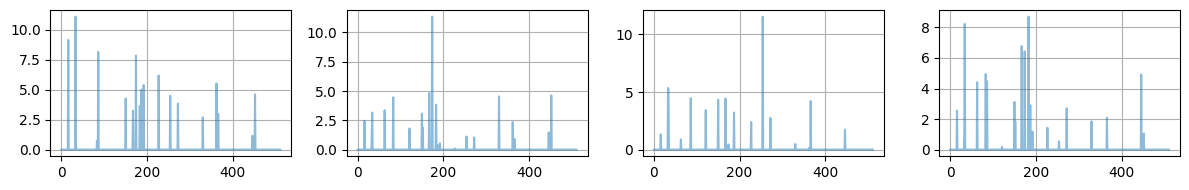

In [103]:

for ax,i in subplots(len(pred)):
    x = image_stack[i,0].detach().cpu().numpy()
    a,b = np.percentile(x, (1,99))
    plt.imshow(x, vmin=a, vmax=b)
    #plt.imshow(x)
    plt.title(batch['timestamp'][i])
    if i==0:
        plt.ylabel("input chhannel 6")
    #plt.axis("off")
    plt.xticks([], []);  plt.yticks([], [])


for ax,i in subplots(len(pred)):
    x = bright_spots[i,0].detach().cpu().numpy()
    plt.imshow(x)
    if i==0:
        plt.ylabel("analytic target")
    plt.xticks([], []);  plt.yticks([], [])
    
for ax,i in subplots(len(pred)):
    x = pred[i,0].detach().cpu().numpy()
    plt.imshow(x)
    if i==0:
        plt.ylabel("prediction")
    plt.xticks([], []);  plt.yticks([], [])

for ax,i in subplots(len(emb), usizey=2):
    x = emb[i].detach().cpu().numpy()
    plt.plot(x, alpha=.5)
    plt.grid();
    


In [94]:
pred.max(), pred.min()

(tensor(0.6452, grad_fn=<MaxBackward1>), tensor(0., grad_fn=<MinBackward1>))

In [95]:
z = model.forward_encode(image_stack)
z.shape

torch.Size([4, 128, 32, 32])

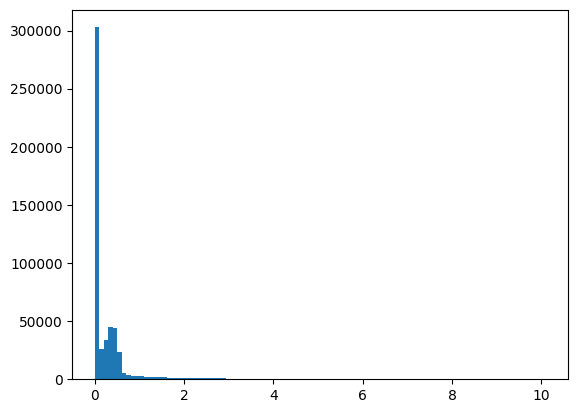

In [35]:
plt.hist(z.detach().cpu().numpy().flatten(), bins=100);

In [34]:
x = image_stack 
self = model
x = self.inc(x)
x = self.down1(x)
x = self.down2(x)
x.shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 14.58 GiB of which 9.38 MiB is free. Process 195569 has 12.57 GiB memory in use. Including non-PyTorch memory, this process has 1.99 GiB memory in use. Of the allocated memory 1.82 GiB is allocated by PyTorch, and 18.12 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
for ax,i in subplots(x.shape[1]):
    plt.imshow(x[2,i].cpu().detach().numpy())
    plt.axis("off")

In [61]:
e = model.forward_encode(image_stack)
e.shape

torch.Size([4, 128, 32, 32])

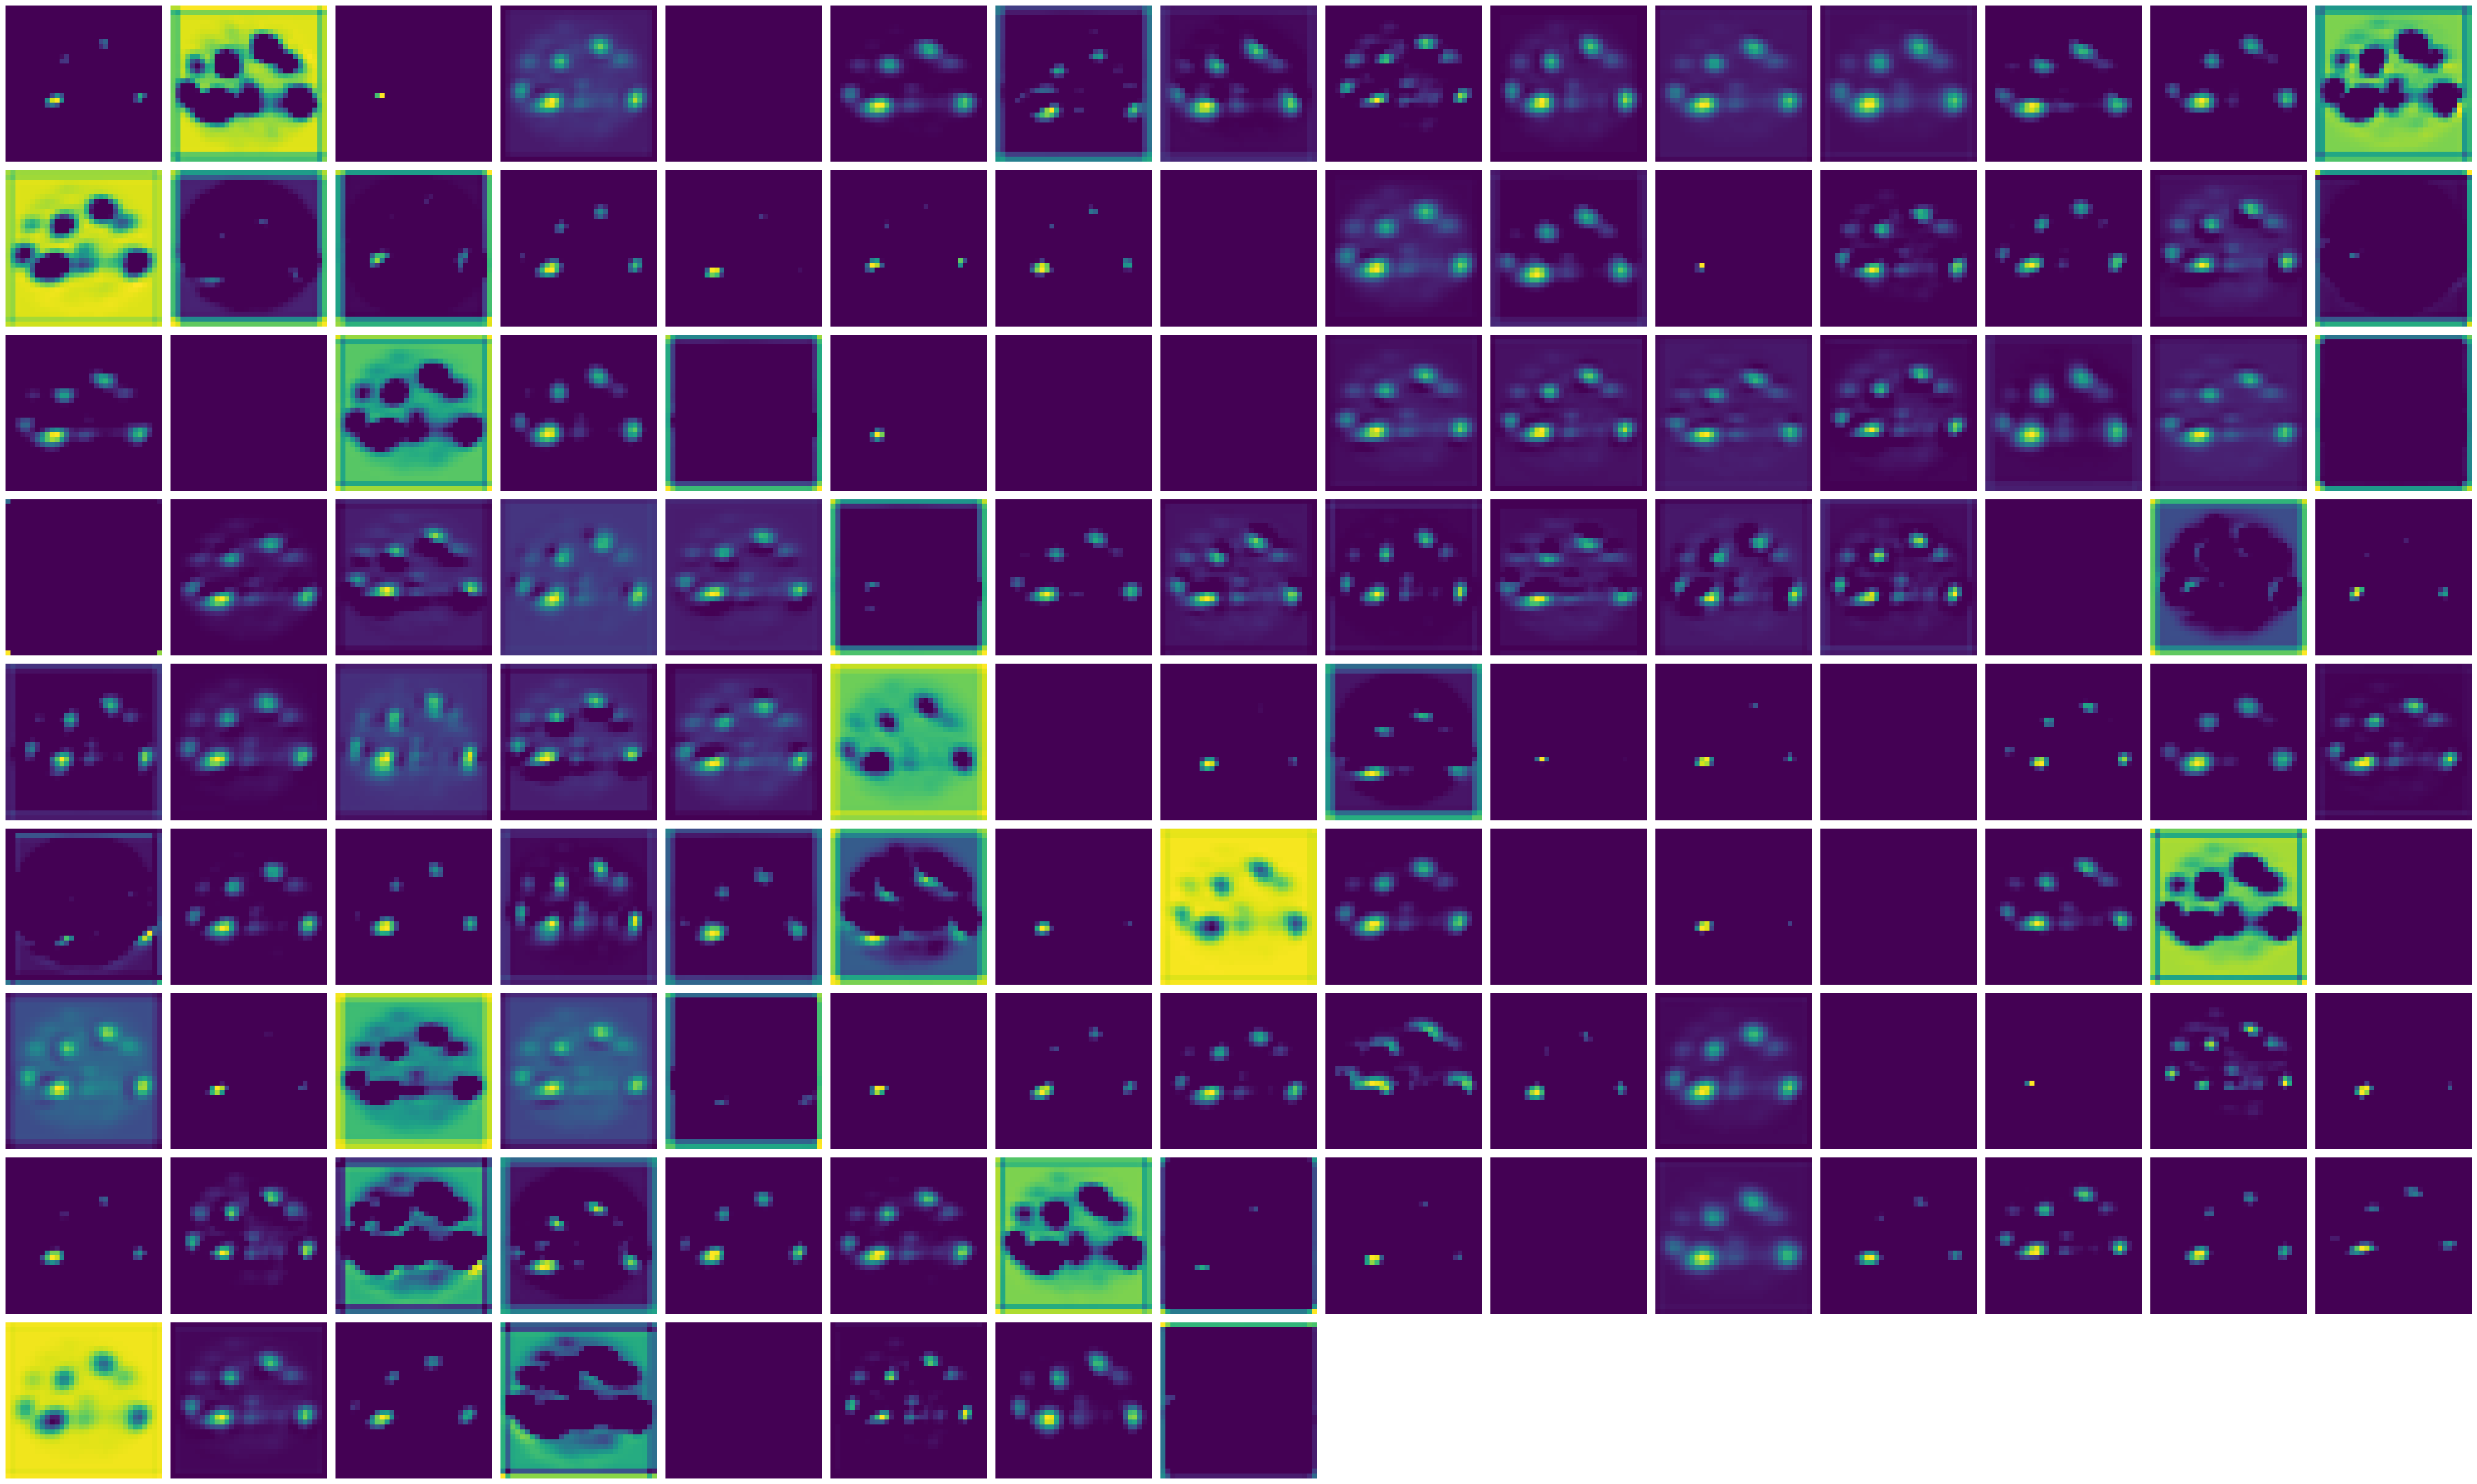

In [62]:
for ax,i in subplots(e.shape[1]):
    plt.imshow(e[2,i].cpu().detach().numpy())
    plt.axis("off")

In [44]:
from torch import nn
import torch.nn.functional as F


In [43]:
F.fla

NameError: name 'F' is not defined

In [12]:
x = model.forward_encode(image_stack)
x.shape

torch.Size([4, 512, 32, 32])

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [19]:
flatten = nn.Flatten()
conv1x1 = nn.Conv2d(512,1,1)
conv512 = nn.Conv2d(1,512,1) 
fc1 = nn.Linear(1024, 512)
fc2 = nn.Linear(512, 512)

fc3 = nn.Linear(512,1024)

In [21]:
x = model.forward_encode(image_stack).cpu()
x = conv1x1(x)
x = flatten(x)
x = F.sigmoid(fc1(x))
x = F.sigmoid(fc2(x))
x = F.sigmoid(fc3(x))
x = x.reshape(-1,1,32,32)
x = F.sigmoid(conv512(x))
x.shape

torch.Size([4, 512, 32, 32])

In [22]:
x = model.forward_decode(x.cuda())

In [23]:
x.shape

torch.Size([4, 64, 512, 512])

In [10]:
image_stack = b['image_stack']
bright_spots = b['bright_spots']

In [11]:
image_stack.shape, bright_spots.shape

(torch.Size([4, 12, 512, 512]), torch.Size([4, 12, 512, 512]))

In [8]:
from importlib import reload

In [49]:
from sdofm.models import unet
reload(unet)

m = unet.UNet(n_channels=12, n_classes=1, bilinear=True)

In [40]:
x = torch.tensor(image_stack).reshape(1, *image_stack.shape)
t = 
x.shape, type(x)

(torch.Size([1, 12, 512, 512]), torch.Tensor)

In [54]:
x = b['image_stack']
o = m(x)[:,0]
o.shape

torch.Size([4, 512, 512])

In [43]:
channel_to_predict = 6

In [53]:
bright_spots[:,channel_to_predict].shape

torch.Size([4, 512, 512])

In [13]:
image_stack = b['image_stack']
bright_spots = b['bright_spots']


In [15]:
preds = model(image_stack.cuda())

In [18]:
preds[:,0].shape, bright_spots[:,6].shape

(torch.Size([4, 512, 512]), torch.Size([4, 512, 512]))

In [20]:
loss_fn(preds[:,0], bright_spots[:,6].cuda())

tensor(0.4839, device='cuda:0', grad_fn=<SqrtBackward0>)